# Análise do Mercado de Dados — Projeto EBAC x Semantix

Este notebook faz parte do meu primeiro projeto de Análise de Dados.  
O objetivo é identificar quais são as **principais hard skills, soft skills e cargos**
mais comuns nas vagas da área de dados, usando dados reais extraídos de:

- LinkedIn (Kaggle)
- Glassdoor (Kaggle)
- Indeed (Kaggle)
- JSearch API (RapidAPI)

Também foi construído um dashboard interativo no Looker Studio.

---


In [42]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted")

# 1. Carregamento das Fontes de Dados

Nesta etapa, importamos os datasets públicos disponíveis no Kaggle e preparamos
a requisição da API JSearch para complementar os dados com vagas mais recentes.



In [43]:
df_glassdoor = pd.read_csv("/content/Glassdor-DataScientist.csv")
df_indeed = pd.read_csv("/content/Indeed-Data Science Jobs List.csv")
df_linkedin = pd.read_csv("/content/Linkedin-clean_jobs.csv")

# Visualização inicial
df_linkedin.head(2), df_glassdoor.head(2), df_indeed.head(2)

(   id         title company           location  \
 0   1  Data Analyst    Meta       New York, NY   
 1   2  Data Analyst    Meta  San Francisco, CA   
 
                                                 link    source date_posted  \
 0  https://www.linkedin.com/jobs/view/data-analys...  LinkedIn  2025-04-14   
 1  https://www.linkedin.com/jobs/view/data-analys...  LinkedIn  2025-04-14   
 
    work_type  employment_type  \
 0        NaN              NaN   
 1        NaN              NaN   
 
                                          description  
 0  The Social Measurement team is a growing team ...  
 1  The Social Measurement team is a growing team ...  ,
    Unnamed: 0  index                          Job Title  \
 0           0      0              Senior Data Scientist   
 1           1      1  Data Scientist, Product Analytics   
 
                 Salary Estimate  \
 0  $111K-$181K (Glassdoor est.)   
 1  $111K-$181K (Glassdoor est.)   
 
                                      Job

## 1.1 Coleta de Dados (JSearch API)


In [45]:
# Requisição da API JSearch API

url = "https://jsearch.p.rapidapi.com/search"
querystring = {"query": "data analyst", "num_pages": "1"}

headers = {
    "X-RapidAPI-Key": "db6c66d720mshc6564ca746f9a3cp1d5e10jsn1aa991b81eb6",
    "X-RapidAPI-Host": "jsearch.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)
data = response.json()

# Dataframe API
df_api = pd.json_normalize(data["data"])
print(df_api.columns)
df_api.head()

Index(['job_id', 'job_title', 'employer_name', 'employer_logo',
       'employer_website', 'job_publisher', 'job_employment_type',
       'job_employment_types', 'job_apply_link', 'job_apply_is_direct',
       'apply_options', 'job_description', 'job_is_remote', 'job_posted_at',
       'job_posted_at_timestamp', 'job_posted_at_datetime_utc', 'job_location',
       'job_city', 'job_state', 'job_country', 'job_latitude', 'job_longitude',
       'job_benefits', 'job_google_link', 'job_min_salary', 'job_max_salary',
       'job_salary_period', 'job_onet_soc', 'job_onet_job_zone',
       'job_highlights.Qualifications', 'job_highlights.Benefits',
       'job_highlights.Responsibilities', 'job_salary'],
      dtype='object')


,job_id,job_title,employer_name,employer_logo,employer_website,job_publisher,job_employment_type,job_employment_types,job_apply_link,job_apply_is_direct,apply_options,job_description,job_is_remote,job_posted_at,job_posted_at_timestamp,job_posted_at_datetime_utc,job_location,job_city,job_state,job_country,job_latitude,job_longitude,job_benefits,job_google_link,job_min_salary,job_max_salary,job_salary_period,job_onet_soc,job_onet_job_zone,job_highlights.Qualifications,job_highlights.Benefits,job_highlights.Responsibilities,job_salary
0,3K1EROP53XTSp3ZLAAAAAA==,"Data Analyst - Policy Strategy & Analytics, Go...",T-Mobile,https://encrypted-tbn0.gstatic.com/images?q=tb...,https://www.t-mobile.com,LinkedIn,Full-time,[FULLTIME],https://www.linkedin.com/jobs/view/data-analys...,False,"[{'publisher': 'LinkedIn', 'apply_link': 'http...","At T-Mobile, we invest in YOU! Our Total Rewar...",False,2 days ago,1.762906e+09,2025-11-12T00:00:00.000Z,"Washington, DC",Washington,District of Columbia,US,38.907192,-77.036871,"[health_insurance, paid_time_off, dental_cover...",https://www.google.com/search?q=jobs&gl=us&hl=...,68000.0,123000.0,YEAR,43911100,4,[This is a hands-on role for someone who can t...,[Our Total Rewards Package ensures that employ...,[You’ll partner with data scientists and data ...,NaN
1,9wRl_BK2u7LPxPq7AAAAAA==,Staff Data Analyst,ExecutivePlacements.com,https://encrypted-tbn0.gstatic.com/images?q=tb...,https://www.executiveplacements.com,LinkedIn,Full-time,[FULLTIME],https://www.linkedin.com/jobs/view/staff-data-...,False,"[{'publisher': 'LinkedIn', 'apply_link': 'http...",Join to apply for the Staff Data Analyst role ...,False,2 days ago,1.762906e+09,2025-11-12T00:00:00.000Z,"Washington, DC",Washington,District of Columbia,US,38.907192,-77.036871,"[health_insurance, paid_time_off, dental_cover...",https://www.google.com/search?q=jobs&gl=us&hl=...,NaN,NaN,None,43911100,4,[We are looking for a Staff Data Analyst who h...,[Below is the annual base salary range for can...,"[In this role, you will be key in creating the...",NaN
2,lGusIpmONY8JR_9-AAAAAA==,"Data Analyst - IT - Chicago, IL",AHU Technologies Inc,https://encrypted-tbn0.gstatic.com/images?q=tb...,None,Indeed,Full-time,[FULLTIME],https://www.indeed.com/viewjob?jk=ec812d70373f...,True,"[{'publisher': 'Indeed', 'apply_link': 'https:...",Job Description\n\nWe are seeking a skilled an...,False,6 hours ago,1.763140e+09,2025-11-14T17:00:00.000Z,"Washington, DC",Washington,District of Columbia,US,38.907192,-77.036871,None,https://www.google.com/search?q=jobs&gl=us&hl=...,30.0,38.0,HOUR,43911100,4,[We are seeking a skilled and experienced Data...,NaN,[The successful candidate will be responsible ...,NaN
3,OKDI82uU80lhWaWDAAAAAA==,New Business Intake Data Analyst,King and Spalding LLP,None,None,ZipRecruiter,Full-time,[FULLTIME],https://www.ziprecruiter.com/c/King-and-Spaldi...,False,"[{'publisher': 'ZipRecruiter', 'apply_link': '...",King & Spalding is a leading global law firm w...,False,2 days ago,1.762906e+09,2025-11-12T00:00:00.000Z,"Washington, DC",Washington,District of Columbia,US,38.907192,-77.036871,"[dental_coverage, paid_time_off, health_insura...",https://www.google.com/search?q=jobs&gl=us&hl=...,73000.0,80000.0,YEAR,43911100,4,"[Strong written and oral communication skills,...",[The firm offers a generous total compensation...,[They must be knowledgeable of the firm's new ...,NaN
4,al3pQjLN4RXjWZc3AAAAAA==,Data Analyst – Federal Operations,CACI,https://encrypted-tbn0.gstatic.com/images?q=tb...,None,CACI Careers,Full-time,[FULLTIME],https://careers.caci.com/global/en/job/CACIGLO...,False,"[{'publisher': 'CACI Careers', 'apply_link': '...",Data Analyst – Federal Operations\n\nJob Categ...,False,None,NaN,None,"Washington, DC",Washington,District of Columbia,US,38.907192,-77.036871,"[paid_time_off, health_insurance]",https://www.google.com/search?q=jobs&gl=us&hl=...,NaN,NaN,None,43911100,4,[Minimum Clearance Required to Start: Top Secr...,[CACI values the unique contri

# 2. Limpeza e Padronização dos Dados

Cada fonte possui nomes de colunas diferentes.  
Aqui, padronizamos tudo para que as bases possam ser unificadas depois.

In [46]:
def clean_linkedin(df):
    df = df.rename(columns=str.lower)
    df = df.rename(columns={
        "work_type": "employment_type"
    })
    df["salary"] = np.nan
    df["source"] = "LinkedIn"
    return df[[
        "title", "company", "employment_type", "description",
        "location", "date_posted", "salary", "link", "source"
    ]]

def clean_glassdoor(df):
    df = df.rename(columns=str.lower)
    df = df.rename(columns={
        "job title": "title",
        "company name": "company",
        "job description": "description",
        "salary estimate": "salary"
    })
    df["employment_type"] = np.nan
    df["date_posted"] = np.nan
    df["link"] = np.nan
    df["source"] = "Glassdoor"
    return df[[
        "title", "company", "employment_type", "description",
        "location", "date_posted", "salary", "link", "source"
    ]]

def clean_indeed(df):
    df = df.rename(columns=str.lower)
    df = df.rename(columns={
        "position": "title",
        "job title": "title",
        "short description": "description",
        "job link": "link",
        "posted at": "date_posted"
    })
    df["employment_type"] = np.nan
    df["source"] = "Indeed"
    return df[[
        "title", "company", "employment_type", "description",
        "location", "date_posted", "salary", "link", "source"
    ]]

def clean_dataset_api(df):
    df = df.rename(columns={
        "job_title": "title",
        "employer_name": "company",
        "job_employment_type": "employment_type",
        "job_description": "description",
        "job_location": "location",
        "job_posted_at_datetime_utc": "date_posted",
        "job_salary": "salary",
        "job_apply_link": "link",
    })
    df["source"] = "JSearch API"
    return df[[
        "title", "company", "employment_type", "description",
        "location", "date_posted", "salary", "link", "source"
    ]]

def clean_common_columns(df):
    df = df.copy()
    df.columns = df.columns.astype(str).str.strip().str.lower()
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df.reset_index(drop=True, inplace=True)
    return df

In [47]:
df_linkedin = clean_linkedin(df_linkedin)
df_glassdoor = clean_glassdoor(df_glassdoor)
df_indeed = clean_indeed(df_indeed)
df_api = clean_dataset_api(df_api)

In [48]:
df_linkedin = clean_common_columns(df_linkedin)
df_glassdoor = clean_common_columns(df_glassdoor)
df_indeed = clean_common_columns(df_indeed)
df_api = clean_common_columns(df_api)

# 3. Unificação dos Dados

In [49]:
cols_final = [
    "title", "company", "employment_type", "description",
    "location", "date_posted", "salary", "link", "source"
]

df_final = pd.concat(
    [df_linkedin[cols_final],
     df_glassdoor[cols_final],
     df_indeed[cols_final],
     df_api[cols_final]],
    ignore_index=True
).drop_duplicates()

print("\n Shape final:", df_final.shape)
df_final.head()


 Shape final: (5167, 9)


,title,company,employment_type,description,location,date_posted,salary,link,source
0,Data Analyst,Meta,NaN,The Social Measurement team is a growing team ...,"New York, NY",2025-04-14,NaN,https://www.linkedin.com/jobs/view/data-analys...,LinkedIn
1,Data Analyst,Meta,NaN,The Social Measurement team is a growing team ...,"San Francisco, CA",2025-04-14,NaN,https://www.linkedin.com/jobs/view/data-analys...,LinkedIn
2,Data Analyst,Meta,NaN,The Social Measurement team is a growing team ...,"Los Angeles, CA",2025-04-14,NaN,https://www.linkedin.com/jobs/view/data-analys...,LinkedIn
3,Data Analyst,Meta,NaN,The Social Measurement team is a growing team ...,"Washington, DC",2025-04-14,NaN,https://www.linkedin.com/jobs/view/data-analys...,LinkedIn
4,Data Analyst II,Pinterest,NaN,About Pinterest\n\nMillions of people around t...,"Chicago, IL",2025-04-16,NaN,https://www.linkedin.com/jobs/view/data-analys...,LinkedIn


# 4. Análise Exploratória de Dados (EDA)

In [50]:
df_final.info()
df_final.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5167 entries, 0 to 5166
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            5167 non-null   object
 1   company          5165 non-null   object
 2   employment_type  10 non-null     object
 3   description      5163 non-null   object
 4   location         5152 non-null   object
 5   date_posted      1049 non-null   object
 6   salary           3971 non-null   object
 7   link             1258 non-null   object
 8   source           5167 non-null   object
dtypes: object(9)
memory usage: 363.4+ KB


,title,company,employment_type,description,location,date_posted,salary,link,source
count,5167,5165,10,5163,5152,1049,3971,1258,5167
unique,2762,2880,3,4818,653,49,208,1258,4
top,Data Analyst,Meta,Full-time,The U.S. Department of the Treasury has a dist...,"New York, NY",2025-06-06,$93K-$151K (Glassdoor est.),https://www.dice.com/job-detail/c10f4626-523e-...,Glassdoor
freq,398,70,8,14,370,108,62,1,3909


=== Cargos com maior número de vagas ===
title
data analyst                         404
data scientist                       352
data engineer                        323
senior data scientist                 93
machine learning engineer             68
senior data analyst                   59
senior data engineer                  50
big data engineer                     43
business intelligence analyst         43
data scientist, product analytics     31
lead data scientist                   24
research scientist                    24
sr. data scientist                    23
junior data analyst                   23
data engineer, product analytics      20
Name: count, dtype: int64


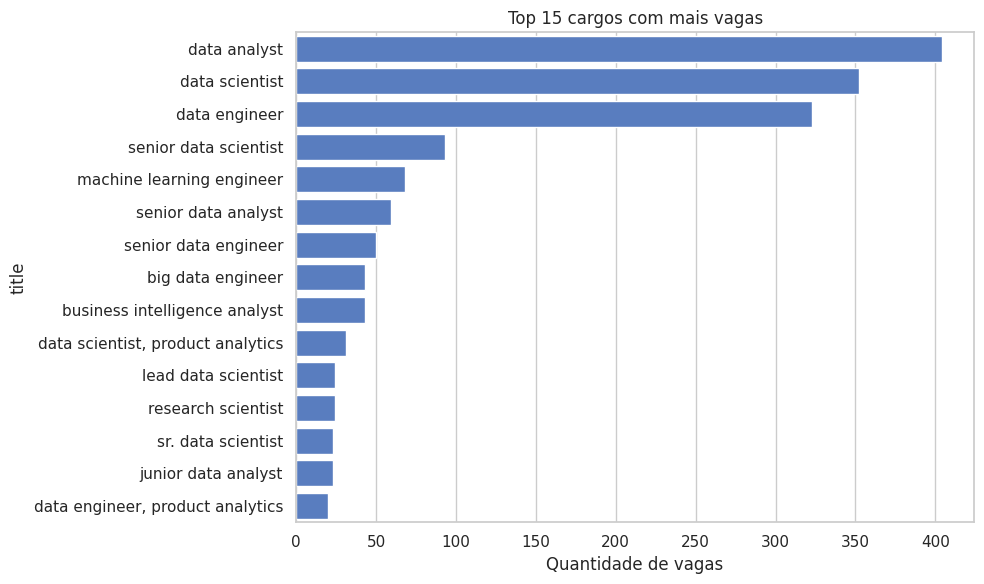

In [51]:
# Cargos
top_titles = (
    df_final["title"]
    .dropna()
    .str.lower()
    .value_counts()
    .head(15)
)

print("=== Cargos com maior número de vagas ===")
print(top_titles)

# Gráfico
plt.figure(figsize=(10,6))
sns.barplot(x=top_titles.values, y=top_titles.index)
plt.title("Top 15 cargos com mais vagas")
plt.xlabel("Quantidade de vagas")
plt.tight_layout()
plt.show()

Top 15 skills mais citadas nas descrições:
python: 2769
sql: 2646
machine learning: 1749
statistics: 1591
r: 1523
data analysis: 1224
spark: 1032
tableau: 948
excel: 880
aws: 825
hadoop: 699
data visualization: 693
azure: 466
power bi: 416
deep learning: 364


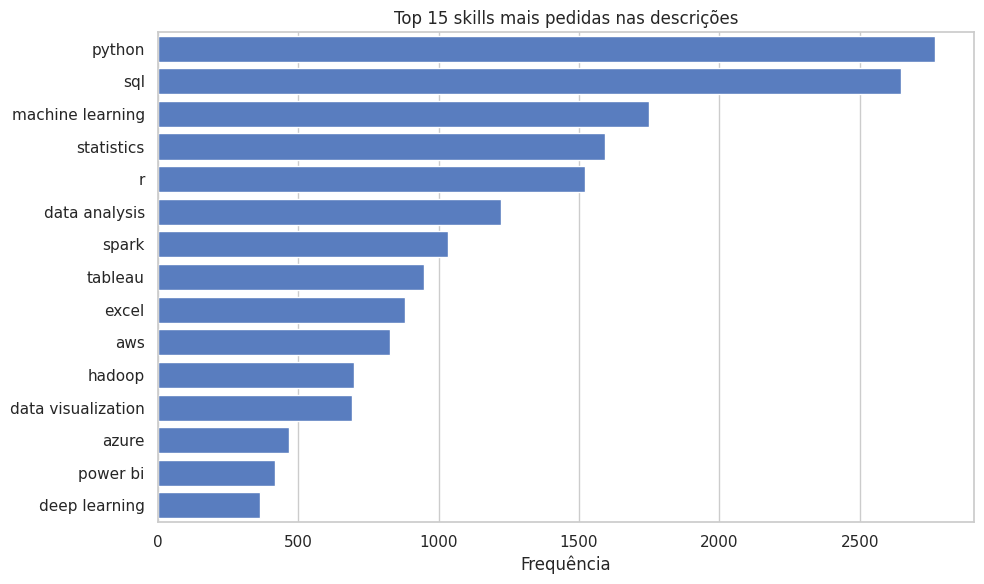

In [52]:
# Hard skills
skills_lista = [
    "python", "sql", "excel", "power bi", "tableau", "r", "aws", "azure",
    "spark", "hadoop", "machine learning", "deep learning", "statistics",
    "data analysis", "data visualization", "numpy", "pandas", "tensorflow",
    "pytorch", "google cloud", "databricks"
]

# Cria um contador
skill_counts = Counter()

# Percorre todas as descrições
for text in df_final["description"].dropna().astype(str):
    text = text.lower()
    for skill in skills_lista:
        # Verifica se a skill aparece como palavra isolada
        if re.search(rf"\b{re.escape(skill)}\b", text):
            skill_counts[skill] += 1

# Mostra as 15 skills mais frequentes
top_skills = skill_counts.most_common(15)

skills = [s for s, c in top_skills]
counts = [c for s, c in top_skills]

print("Top 15 skills mais citadas nas descrições:")
for skill, count in top_skills:
    print(f"{skill}: {count}")

# Gráfico
plt.figure(figsize=(10,6))
sns.barplot(x=list(counts), y=list(skills))
plt.title("Top 15 skills mais pedidas nas descrições")
plt.xlabel("Frequência")
plt.tight_layout()
plt.show()

Top 15 Soft Skills mais citadas nas descrições:
communication: 2902
creativity: 1812
leadership: 1548
collaboration: 1430
problem solving: 1314
adaptability: 1013
attention to detail: 975
teamwork: 585
self motivation: 547
analytical thinking: 466
decision making: 453
proactivity: 449
project management: 394
time management: 309
critical thinking: 285


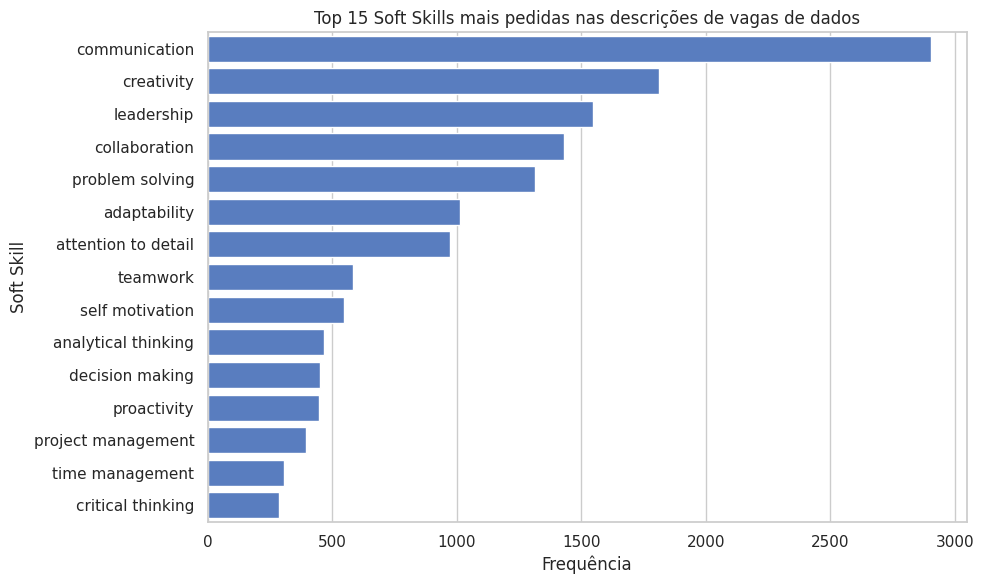

In [53]:
# Soft skills
soft_skills_dict = {
    "communication": ["communication", "communicator", "communicate", "communication skills", "good communication", "verbal communication", "written communication"],
    "problem solving": ["problem solving", "problem-solving", "solving problems", "solution oriented", "troubleshooting"],
    "critical thinking": ["critical thinking", "think critically", "analytical mindset"],
    "teamwork": ["teamwork", "team player", "collaborate with team", "working in a team", "cross-functional team"],
    "collaboration": ["collaboration", "collaborative", "work collaboratively", "partnering with others"],
    "adaptability": ["adaptability", "adaptable", "flexibility", "flexible", "handle change"],
    "creativity": ["creativity", "creative thinking", "innovative", "innovation"],
    "leadership": ["leadership", "leader", "leading projects", "mentorship", "managing people"],
    "attention to detail": ["attention to detail", "detail oriented", "meticulous", "accuracy"],
    "time management": ["time management", "manage deadlines", "multitasking", "prioritization", "organization skills"],
    "analytical thinking": ["analytical thinking", "analytical mindset", "analytical skills"],
    "decision making": ["decision making", "make decisions", "sound judgment"],
    "project management": ["project management", "manage projects", "project coordination"],
    "self motivation": ["self motivation", "self-motivated", "independent worker", "work independently"],
    "proactivity": ["proactivity", "proactive", "initiative", "take initiative"],
    "empathy": ["empathy", "empathetic", "understanding others"],
    "resilience": ["resilience", "resilient", "work under pressure"],
    "curiosity": ["curiosity", "curious mindset", "continuous learner"]
}

# Cria um contador
soft_skill_counts = Counter()

# Percorre todas as descrições
for text in df_final["description"].dropna().astype(str):
    text = text.lower()
    for skill, variations in soft_skills_dict.items():
        for variant in variations:
            if re.search(rf"\b{re.escape(variant)}\b", text):
                soft_skill_counts[skill] += 1
                break

# Top 15 soft skills mais citadas
top_soft_skills = soft_skill_counts.most_common(15)

print("Top 15 Soft Skills mais citadas nas descrições:")
for skill, count in top_soft_skills:
    print(f"{skill}: {count}")

# Gráfico
plt.figure(figsize=(10,6))
sns.barplot(
    x=[count for _, count in top_soft_skills],
    y=[skill for skill, _ in top_soft_skills]
)
plt.title("Top 15 Soft Skills mais pedidas nas descrições de vagas de dados")
plt.xlabel("Frequência")
plt.ylabel("Soft Skill")
plt.tight_layout()
plt.show()

In [54]:
#Empresas

top_companies = df_final['company'].value_counts().head(15)
print(top_companies)

company
Meta                                     70
Apple\n4.1                               60
IBM\n3.7                                 57
Amazon\n3.9                              47
Netflix                                  33
Staffigo Technical Services, LLC\n5.0    28
Facebook\n4.5                            25
Diverse Lynx\n3.9                        25
Solekai Systems Corp\n4.2                24
Southwest Research Institute\n4.1        23
Varsity Tutors\n4.2                      21
Humana\n3.6                              20
GSK\n3.9                                 18
CyberCoders\n4.2                         18
Amazon                                   18
Name: count, dtype: int64


# 5. Exportação para o Looker Studio

In [ ]:
top_titles = (
    df_final["title"]
    .dropna()
    .str.strip()
    .value_counts()
    .reset_index()
)
top_titles.columns = ["cargo", "quantidade"]
top_titles.to_csv("vagas_por_cargo.csv", index=False)

In [ ]:
hard_skills_df = pd.DataFrame(skill_counts.most_common(), columns=["hard_skill", "quantidade"])
hard_skills_df.to_csv("top_hard_skills.csv", index=False)

In [ ]:
soft_skills_df = pd.DataFrame(soft_skill_counts.most_common(), columns=["soft_skill", "quantidade"])
soft_skills_df.to_csv("top_soft_skills.csv", index=False)

In [ ]:
top_companies = (
    df_final["company"]
    .dropna()
    .str.replace("\n.*","", regex=True)
    .str.strip()
    .value_counts()
    .reset_index()
)
top_companies.columns = ["empresa", "quantidade"]
top_companies.to_csv("vagas_por_empresa.csv", index=False)

In [ ]:
df_final_visao = df_final[["title","company","location","date_posted","source"]].copy()
df_final_visao.to_csv("visao_geral_vagas.csv", index=False)

# 6. Conclusão do Notebook

Este foi meu primeiro projeto de Análise de Dados.
Aprendi na prática como trabalhar com múltiplas fontes de dados,
limpar e padronizar informações diferentes e montar visualizações úteis para o mercado.

A análise completa pode ser vista no dashboard:

🔗 https://lookerstudio.google.com/reporting/36dc484a-ee74-4caa-b858-1bfd3724ac66

---
